In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

In [2]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
mnist_train = torchvision.datasets.MNIST(".", train=True, download=True, transform=mnist_transform)
mnist_test = torchvision.datasets.MNIST(".", train=False, download=True, transform=mnist_transform)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 459kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.28MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.22MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
from torch.utils.data import random_split

In [5]:
# Define split ratios
train_size = int(0.8 * len(mnist_train))
val_size = int(0.2 * len(mnist_train))

# Split dataset
train_dataset, val_dataset = random_split(mnist_train, [train_size, val_size])

In [6]:
from torch.utils.data import DataLoader

In [7]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

pred_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
def _weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.ConvTranspose2d(100, 1024, 3, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            nn.ConvTranspose2d(1024, 512, 3, 2, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        ])

        self.apply(_weights_init)

    def forward(self, x):
        x = x.unsqueeze(-1).unsqueeze(-1) # [batch_size, 100] => [batch_size, 100, 1, 1]
        for layer in self.layers:
            x = layer(x)
        return x

In [11]:
generator = Generator()

In [12]:
class Discrimiator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(1, 256, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1024, 3, 2, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(1024, 1, 3, 1, 0, bias=False),
        ])

        self.apply(_weights_init)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x.view(x.shape[0], -1)

In [13]:
adv = Discrimiator()

In [14]:
import torch.nn.functional as F

def adversarialLoss(d_x, d_g_z, gp, lambda_gp):
    return -d_x.mean() + d_g_z.mean() + lambda_gp * gp

def generatorLoss(d_g_z):
    return -d_g_z.mean()

In [15]:
def gradientPenalty(real_data, gen_data, adv):
    epsilon = torch.randn((batch_size, 1, 1, 1)).repeat(1, 1, 28, 28).to(device)
        
    interpolated_img = epsilon * real_data + (1 - epsilon) * gen_data
    # print(f"gen_data: {noise}")
    # print(f"gen_data.shape: {gen_data.shape}")
    
    pred_interpolated_data = adv(interpolated_img)
    # print(f"pred_gen_data: {pred_gen_data}")
    # print(f"pred_gen_data.shape: {pred_gen_data.shape}")

    # loss
    gradient = torch.autograd.grad(
        inputs = interpolated_img,
        outputs = pred_interpolated_data,
        grad_outputs = torch.ones_like(pred_interpolated_data),
        create_graph = True,
        retain_graph = True
    )[0] # d(pred_interpolated_data) / d(interpolated_img)

    gradient = gradient.view(gradient.shape[0], -1) # flatten with graident.shape[0] being num of examples
    gradient_norm = gradient.norm(2, dim=1) # dim is 1 with data
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)

    return gradient_penalty

In [16]:
import math
import itertools

In [17]:
learning_rate = 2e-4
k = 5
c = 0.01
lambda_gp = 10

# less epoch as can easily overfit
num_epoch = 20000

lossi_gen = []
lossi_adv = []

total_samples = len(train_loader)

advOptimizer = torch.optim.AdamW(adv.parameters(), lr=learning_rate, betas=(0.5, 0.999))
generatorOptimizer = torch.optim.AdamW(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

generator = generator.to(device)
adv = adv.to(device)

train_loader_iter_adv_training = itertools.cycle(iter(train_loader))

for epoch in range(num_epoch):
    adv.train()
    generator.eval()
    
    for _ in range(k):
        advOptimizer.zero_grad()
        
        feature, _ = next(train_loader_iter_adv_training)
        feature = feature.to(device)
        # print(f"feature: {feature}")
        # print(f"feature.shape: {feature.shape}")

        pred_data = adv(feature)
        # print(f"pred_data: {pred_data}")
        # print(f"pred_data.shape: {pred_data.shape}")

        noise = torch.randn(batch_size, 100)
        noise = noise.to(device)
        # print(f"noise: {noise}")
        # print(f"noise.shape: {noise.shape}")
    
        gen_data = generator(noise)
        # print(f"gen_data: {noise}")
        # print(f"gen_data.shape: {gen_data.shape}")
        
        pred_gen_data = adv(gen_data)
        # print(f"pred_gen_data: {pred_gen_data}")
        # print(f"pred_gen_data.shape: {pred_gen_data.shape}")

        # loss
        gp = gradientPenalty(feature, gen_data, adv)
        advLoss = adversarialLoss(pred_data, pred_gen_data, gp, lambda_gp)

        advLoss.backward()
        advOptimizer.step()

        for p in adv.parameters():
            p.data.clamp_(-c, c)

        lossi_adv.append(advLoss.detach().cpu())

        # raise Exception("Error")

    generatorOptimizer.zero_grad()

    adv.eval()
    generator.train()

    noise = torch.randn(batch_size, 100)
    noise = noise.to(device)
    # print(f"noise: {noise}")
    # print(f"noise.shape: {noise.shape}")

    gen_data = generator(noise)
    # print(f"gen_data: {noise}")
    # print(f"gen_data.shape: {gen_data.shape}")

    pred_gen_data = adv(gen_data)
    # print(f"pred_gen_data: {pred_gen_data}")
    # print(f"pred_gen_data.shape: {pred_gen_data.shape}")
    
    # loss
    genLoss = generatorLoss(pred_gen_data)

    genLoss.backward()
    generatorOptimizer.step()

    lossi_gen.append(genLoss.detach().cpu())

    if ((epoch+1)%100==0):
        print(f"Epoch {epoch+1}/{num_epoch}, Adversial Loss: {advLoss.item():.4f}, Generator Loss: {genLoss.item():.4f}")

Epoch 100/20000, Adversial Loss: -0.6698, Generator Loss: 0.0057
Epoch 200/20000, Adversial Loss: 1.2770, Generator Loss: -0.2190
Epoch 300/20000, Adversial Loss: -1.2626, Generator Loss: 0.2243
Epoch 400/20000, Adversial Loss: 3.5745, Generator Loss: 0.6120
Epoch 500/20000, Adversial Loss: -1.2486, Generator Loss: 0.1296
Epoch 600/20000, Adversial Loss: -0.5625, Generator Loss: 0.0064
Epoch 700/20000, Adversial Loss: -0.0942, Generator Loss: 0.0041
Epoch 800/20000, Adversial Loss: -0.0492, Generator Loss: 0.5138
Epoch 900/20000, Adversial Loss: -0.1870, Generator Loss: -0.1212
Epoch 1000/20000, Adversial Loss: -0.9389, Generator Loss: 0.1844
Epoch 1100/20000, Adversial Loss: 0.5264, Generator Loss: 0.6141
Epoch 1200/20000, Adversial Loss: 0.1015, Generator Loss: 0.2064
Epoch 1300/20000, Adversial Loss: -0.3514, Generator Loss: 0.4737
Epoch 1400/20000, Adversial Loss: -1.1307, Generator Loss: -0.0754
Epoch 1500/20000, Adversial Loss: -1.0296, Generator Loss: 0.0880
Epoch 1600/20000, Ad

In [18]:
import matplotlib.pyplot as plt

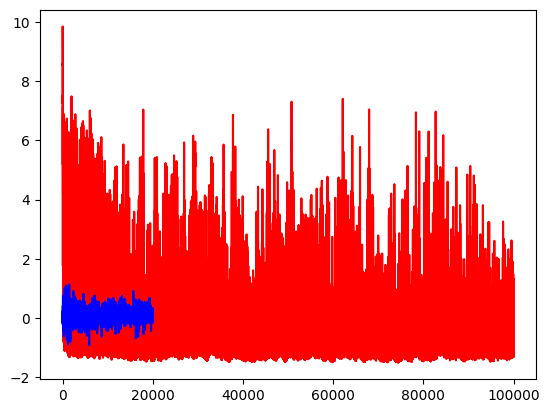

In [19]:
plt.plot(lossi_adv, c="red")
plt.plot(lossi_gen, c="blue")

torch.Size([1, 1, 28, 28])


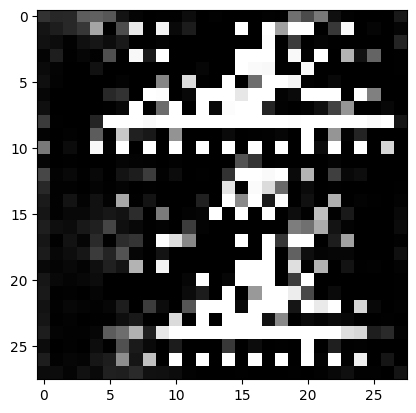

In [20]:
generator.eval()

with torch.no_grad():
    noise = torch.randn(1,100)
    noise = noise.to(device)
    
    gen_img = generator(noise)
    print(gen_img.shape)
    img = gen_img.view(1, 28, 28)
    
    plt.imshow(img.squeeze().cpu(), cmap="gray")
    plt.show()